In [ ]:
import pandas as pd
import os, bz2, json, time
from datetime import timedelta
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import re
import ast
from PIL import Image
import requests
import seaborn as sns
import nltk
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.functional as F

In [ ]:
# data_en = pd.read_csv('Data1_en.csv')
data_ru = pd.read_csv('Data1_ru.csv')
data = data_ru

In [ ]:
# test_en = pd.read_csv('Test1_en.csv')
test_ru = pd.read_csv('Test1_ru.csv')
data = test_ru

In [ ]:
replacer = dict()

with open('category-codes.txt') as f:
    categories = f.read().splitlines()
    for cat in categories:
        replacer[int(cat.split(' - ')[0])] = cat.split(' - ')[1]

In [ ]:
text_columns = ['title', 'description', 'tags']
categorical_columns = ['categoryId', 'published_weekday', 'published_category', 'caps', 'link', 'duration_category']
TARGET_COLUMN = "Log1pViews"

data['categoryId'] = data['categoryId'].replace(replacer)
data['duration_category'] = data['duration_category'].fillna('Medium')
data[categorical_columns[:-1]] = data[categorical_columns[:-1]].fillna('NaN')
data['title'] = data['title'].fillna('NaN')
data['description'] = data['description'].str.replace(r'http\S+', '').fillna('NaN')
data['tags'] = data['tags'].str.replace('|', ', ').replace('[None]', 'NaN')

data.sample(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # Remove the CWD from sys.path while we load stuff.


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,...,caption,defaultLanguage,regionRestriction,Log1pViews,published_category,published_weekday,duration_category,caps,link,main_color
5581,Ecde0eoFEmw,Тоттенхэм - Маккаби. Лучшие моменты матча Лиги...,2020-10-01T22:25:21Z,UC9q_Stc4DXWrUPQ8DFEdWDQ,Okko Спорт,Sports,2020-10-02T00:00:00Z,"Тоттенхэм, Маккаби, Лига Европы, Обзор",17981,278,...,False,NaN,NaN,9.797127,Evening,Thi,VeryLong,Not used,Used,lavender
29182,DqYfJsTLMhU,3 ДНЯ ЖИВУ КАК БОМЖ! Сплю на ЗАБРОШКЕ,2021-05-18T19:27:06Z,UCwipTluVS2mjuhPtx2WU7eQ,Дима Масленников,Entertainment,2021-05-19T00:00:00Z,"3 ДНЯ ЖИВУ КАК БОМЖ, 3 ДНЯ БОМЖОМ, СТАЛ БОМЖОМ...",1681984,242606,...,False,NaN,NaN,14.335485,Evening,Tue,Small,Not used,Used,black
50431,CPYenr3qJw8,ДОМ-2. День (эфир от 30.11.2021),2021-11-30T10:00:10Z,UCiMKJainDWz6Lf8vFC4tuRg,ДОМ-2,Entertainment,2021-12-01T00:00:00Z,"дом 2 онлайн, дом 2 смотреть, свежие серии дом...",208256,1076,...,False,NaN,NaN,12.246529,Morning,Tue,Small,Not used,Used,black


In [ ]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
tok_mwe = nltk.tokenize.ToktokTokenizer()
data["description"] = data["description"].apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())))
data["title"] = data["title"].apply(lambda x: ' '.join(tokenizer.tokenize(str(x).lower())))
data["tags"] = data["tags"].apply(lambda x: ' '.join(''.join(str(x).lower().split(' ')).split(',')))

In [ ]:
token_counts = Counter()

for row in data.iterrows():
    token_counts.update([*row[1]['description'].split(), *row[1]['title'].split(), *row[1]['tags'].split()])

In [ ]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 672812
(':', 419525)
(',', 364202)
('-', 300517)
('.', 293966)
('в', 191472)
...
('mrr', 1)
('восьмидесятые5сезон8серия', 1)
('восьмидесятые80серия', 1)


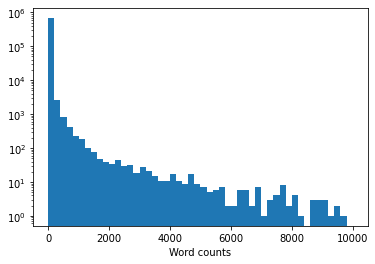

In [ ]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [ ]:
min_count = 5
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens
print("Vocabulary size:", len(tokens))

Vocabulary size: 120529


In [ ]:
token_to_id = dict(zip(tokens, [i for i in range(len(tokens))]))

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """
    Convert a list of tokens into a matrix with padding
    """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [ ]:
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [ ]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  52948
Validation size =  13238


In [ ]:
DEVICE = torch.device('cuda')

In [ ]:
def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["description", "title", 'tags']:
            batch_tensors[key] = torch.tensor(arr, dtype=torch.int64, device=device)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=DEVICE):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["title"] = as_matrix(data["title"].values, max_len)
    batch["description"] = as_matrix(data["description"].values, max_len)
    batch["tags"] = as_matrix(data["tags"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["description"] = apply_word_dropout(batch["description"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)


def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [ ]:
class ViewsPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=n_tokens,
                                      embedding_dim=hid_size,
                                      padding_idx=0,
                                      max_norm=5.0).to(DEVICE)
        
        self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                              out_channels=100,
                                              kernel_size=(fs, hid_size)) for fs in [1, 2, 3, 4]]).to(DEVICE)

        self.lstm = nn.LSTM(64, hidden_size=hid_size, batch_first=True, bidirectional=True).to(DEVICE)
        self.fc = nn.Linear(hid_size * 2, 100).to(DEVICE)

        self.hidden = nn.Linear(200, 100).to(DEVICE)
                
        self.max_pool = nn.AdaptiveMaxPool1d(2).to(DEVICE)
        self.avg_pool = nn.AdaptiveAvgPool1d(2).to(DEVICE)
        
        self.categories1 = nn.Linear(n_cat_features, 300).to(DEVICE)
        self.norm_cat = nn.BatchNorm1d(300, momentum=0.1).to(DEVICE)
        self.categories2 = nn.Linear(300, 100).to(DEVICE)
        
        self.relu = nn.ReLU().to(DEVICE)
        self.dropout = nn.Dropout(0.5).to(DEVICE)
        
        self.fc1 = nn.Linear(100 * 49, hid_size, bias=True).to(DEVICE)
        self.fc2 = nn.Linear(hid_size, 1, bias=True).to(DEVICE)
        
        
    def forward(self, batch):
        # emb
        x_embed_title = self.embedding(batch['title']).unsqueeze(1)
        x_embed_description = self.embedding(batch['description']).unsqueeze(1)
        x_embed_tags = self.embedding(batch['tags']).unsqueeze(1)
            
        # # conv
        convolution_title = [conv(x_embed_title) for conv in self.convs]
        convolution_description = [conv(x_embed_description) for conv in self.convs]
        convolution_tags = [conv(x_embed_tags) for conv in self.convs]
       
        # # pooling
        max_title = torch.cat([self.max_pool(conv_title.squeeze().unsqueeze(2 if batch['title'].shape[0] != 1 else 0))
                     if len(conv_title.squeeze().shape) < 3 else self.max_pool(conv_title.squeeze())
                     for conv_title in convolution_title], dim=2)
        
        avg_title = torch.cat([self.avg_pool(conv_title.squeeze().unsqueeze(2 if batch['title'].shape[0] != 1 else 0))
                     if len(conv_title.squeeze().shape) < 3 else self.avg_pool(conv_title.squeeze())
                     for conv_title in convolution_title], dim=2)
        
        title = torch.cat([max_title, avg_title], dim=-1)

        # h0 = torch.randn(2, batch['title'].shape[0], 64, device=DEVICE)
        # c0 = torch.randn(2, batch['title'].shape[0], 64, device=DEVICE)
        # recurrent_title, (_,_) = self.lstm(x_embed_title.squeeze(1), (h0, c0))
        # title = self.max_pool(self.fc(recurrent_title).permute(0, 2, 1)) 

        # title = torch.cat([title1, title2], dim=2)
        
        max_description = torch.cat([self.max_pool(conv_description.squeeze().unsqueeze(2 if batch['description'].shape[0] != 1 else 0)) 
                     if len(conv_description.squeeze().shape) < 3 else self.max_pool(conv_description.squeeze())
                     for conv_description in convolution_description], dim=2)
        
        avg_description = torch.cat([self.avg_pool(conv_description.squeeze().unsqueeze(2 if batch['description'].shape[0] != 1 else 0)) 
                     if len(conv_description.squeeze().shape) < 3 else self.avg_pool(conv_description.squeeze())
                     for conv_description in convolution_description], dim=2)
        
        description = torch.cat([max_description, avg_description], dim=-1) 

        # h0 = torch.randn(2, batch['description'].shape[0], 64, device=DEVICE)
        # c0 = torch.randn(2, batch['description'].shape[0], 64, device=DEVICE)
        # recurrent_description, (_,_) = self.lstm(x_embed_description.squeeze(1), (h0, c0))
        # description = self.max_pool(self.fc(recurrent_description).permute(0, 2, 1)) 

        # description = torch.cat([description1, description2], dim=2)
        
        max_tags = torch.cat([self.max_pool(conv_tags.squeeze().unsqueeze(2 if batch['tags'].shape[0] != 1 else 0)) 
                     if len(conv_tags.squeeze().shape) < 3 else self.max_pool(conv_tags.squeeze())
                     for conv_tags in convolution_tags], dim=2)
        
        avg_tags = torch.cat([self.avg_pool(conv_tags.squeeze().unsqueeze(2 if batch['tags'].shape[0] != 1 else 0)) 
                     if len(conv_tags.squeeze().shape) < 3 else self.avg_pool(conv_tags.squeeze())
                     for conv_tags in convolution_tags], dim=2)
        
        tags = torch.cat([max_tags, avg_tags], dim=-1)  

        # h0 = torch.randn(2, batch['tags'].shape[0], 64, device=DEVICE)
        # c0 = torch.randn(2, batch['tags'].shape[0], 64, device=DEVICE)
        # recurrent_tags, (_,_) = self.lstm(x_embed_tags.squeeze(1), (h0, c0))
        # tags = self.max_pool(self.fc(recurrent_tags).permute(0, 2, 1)) 

        # tags = torch.cat([tags1, tags2], dim=2)
        
        # categories
        categories = self.categories2(self.norm_cat(self.categories1(batch['Categorical']))).unsqueeze(1).permute(0, 2, 1)
        
        #concat
        cat = torch.cat((title, description, tags, categories), dim=2)
        
        out = cat.view(cat.shape[0], -1)        
        out = self.fc1(self.relu(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out.reshape(-1)

In [ ]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=DEVICE, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

In [ ]:
BATCH_SIZE = 16
EPOCHS = 100

In [ ]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    valid_losses = []
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
            loss = criterion(batch_pred, batch[TARGET_COLUMN])
            valid_losses.append(loss.item())
    valid_loss = np.average(valid_losses)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae, valid_loss

In [ ]:
model = ViewsPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
# early_stopping = EarlyStopping(patience=10, verbose=True, monitor="val_loss")


for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN].float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    mse, mae, valid_loss = print_metrics(model, data_val)

epoch: 0


3310it [05:05, 10.84it/s]                          


 results:
Mean square error: 1.30623
Mean absolute error: 0.89121
epoch: 1


3310it [05:04, 10.88it/s]


 results:
Mean square error: 1.26355
Mean absolute error: 0.88505
epoch: 2


3310it [05:03, 10.90it/s]


 results:
Mean square error: 0.81476
Mean absolute error: 0.69550
epoch: 3


3310it [05:01, 10.98it/s]                          


 results:
Mean square error: 0.78120
Mean absolute error: 0.68405
epoch: 4


3310it [05:01, 10.98it/s]                          


 results:
Mean square error: 0.65958
Mean absolute error: 0.61530
epoch: 5


3310it [05:02, 10.95it/s]


 results:
Mean square error: 0.91805
Mean absolute error: 0.76723
epoch: 6


3310it [05:02, 10.94it/s]                          


 results:
Mean square error: 0.58311
Mean absolute error: 0.57671
epoch: 7


3310it [05:02, 10.93it/s]


 results:
Mean square error: 0.59969
Mean absolute error: 0.59204
epoch: 8


3310it [05:03, 10.92it/s]


 results:
Mean square error: 0.54525
Mean absolute error: 0.55730
epoch: 9


3310it [05:03, 10.92it/s]


 results:
Mean square error: 0.53851
Mean absolute error: 0.55331
epoch: 10


3310it [05:00, 11.02it/s]                          


 results:
Mean square error: 0.53994
Mean absolute error: 0.55708
epoch: 11


3310it [05:02, 10.95it/s]


 results:
Mean square error: 0.52694
Mean absolute error: 0.54769
epoch: 12


3310it [05:00, 11.00it/s]                          


 results:
Mean square error: 0.55152
Mean absolute error: 0.56716
epoch: 13


3310it [04:59, 11.04it/s]


 results:
Mean square error: 0.51542
Mean absolute error: 0.54206
epoch: 14


3310it [05:03, 10.92it/s]


 results:
Mean square error: 0.54768
Mean absolute error: 0.56386
epoch: 15


3310it [05:02, 10.93it/s]


 results:
Mean square error: 0.52305
Mean absolute error: 0.54760
epoch: 16


3310it [05:02, 10.96it/s]


 results:
Mean square error: 0.54307
Mean absolute error: 0.56255
epoch: 17


3310it [05:02, 10.95it/s]


 results:
Mean square error: 0.52159
Mean absolute error: 0.54664
epoch: 18


3310it [05:03, 10.92it/s]                          


 results:
Mean square error: 0.52354
Mean absolute error: 0.54902
epoch: 19


3310it [05:02, 10.93it/s]


 results:
Mean square error: 0.52377
Mean absolute error: 0.54753
epoch: 20


3310it [05:01, 10.98it/s]                          


 results:
Mean square error: 0.57611
Mean absolute error: 0.58371
epoch: 21


3310it [05:02, 10.94it/s]                          


 results:
Mean square error: 0.53939
Mean absolute error: 0.55933
epoch: 22


3310it [05:02, 10.93it/s]                          


 results:
Mean square error: 0.54506
Mean absolute error: 0.56153
epoch: 23


3310it [05:03, 10.90it/s]                          


 results:
Mean square error: 0.53764
Mean absolute error: 0.55657
epoch: 24


3310it [05:03, 10.90it/s]                          


 results:
Mean square error: 0.55960
Mean absolute error: 0.57182
epoch: 25


3310it [05:05, 10.82it/s]                          


 results:
Mean square error: 0.53414
Mean absolute error: 0.55443
epoch: 26


3310it [05:05, 10.82it/s]                          


 results:
Mean square error: 0.54284
Mean absolute error: 0.55971
epoch: 27


3310it [05:06, 10.81it/s]                          


 results:
Mean square error: 0.54296
Mean absolute error: 0.55913
epoch: 28


3310it [05:02, 10.92it/s]                          


 results:
Mean square error: 0.55901
Mean absolute error: 0.56906
epoch: 29


3310it [05:03, 10.91it/s]


 results:
Mean square error: 0.54633
Mean absolute error: 0.56251
epoch: 30


3310it [05:07, 10.76it/s]                          


 results:
Mean square error: 0.54905
Mean absolute error: 0.56469
epoch: 31


3310it [05:05, 10.83it/s]                          


 results:
Mean square error: 0.58763
Mean absolute error: 0.58551
epoch: 32


3310it [05:07, 10.75it/s]


 results:
Mean square error: 0.54917
Mean absolute error: 0.56299
epoch: 33


3310it [05:07, 10.77it/s]


 results:
Mean square error: 0.57589
Mean absolute error: 0.57858
epoch: 34


3310it [05:02, 10.93it/s]


 results:
Mean square error: 0.55674
Mean absolute error: 0.56657
epoch: 35


 12%|█▏        | 412/3309 [00:37<04:30, 10.70it/s]

In [ ]:
model = ViewsPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
# early_stopping = EarlyStopping(patience=10, verbose=True, monitor="val_loss")


for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN].float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    mse, mae, valid_loss = print_metrics(model, data_val)

epoch: 0


3310it [05:03, 10.90it/s]


 results:
Mean square error: 1.16580
Mean absolute error: 0.85759
epoch: 1


3310it [04:59, 11.05it/s]                          


 results:
Mean square error: 0.97113
Mean absolute error: 0.77110
epoch: 2


3310it [04:58, 11.10it/s]


 results:
Mean square error: 0.80312
Mean absolute error: 0.68810
epoch: 3


3310it [05:00, 11.03it/s]                          


 results:
Mean square error: 0.71128
Mean absolute error: 0.64164
epoch: 4


3310it [04:59, 11.06it/s]                          


 results:
Mean square error: 0.78700
Mean absolute error: 0.68898
epoch: 5


3310it [04:59, 11.04it/s]                          


 results:
Mean square error: 0.80465
Mean absolute error: 0.70273
epoch: 6


3310it [04:58, 11.10it/s]


 results:
Mean square error: 0.61690
Mean absolute error: 0.59953
epoch: 7


3310it [04:57, 11.12it/s]


 results:
Mean square error: 0.56178
Mean absolute error: 0.56454
epoch: 8


3310it [04:57, 11.13it/s]                          


 results:
Mean square error: 0.54830
Mean absolute error: 0.55722
epoch: 9


3310it [04:59, 11.06it/s]                          


 results:
Mean square error: 0.61290
Mean absolute error: 0.60293
epoch: 10


3310it [04:58, 11.09it/s]                          


 results:
Mean square error: 0.52320
Mean absolute error: 0.54480
epoch: 11


3310it [04:58, 11.10it/s]                          


 results:
Mean square error: 0.53191
Mean absolute error: 0.55036
epoch: 12


3310it [04:58, 11.09it/s]                          


 results:
Mean square error: 0.51783
Mean absolute error: 0.54316
epoch: 13


3310it [04:56, 11.16it/s]


 results:
Mean square error: 0.51264
Mean absolute error: 0.53945
epoch: 14


3310it [04:58, 11.07it/s]                          


 results:
Mean square error: 0.52347
Mean absolute error: 0.54816
epoch: 15


3310it [04:59, 11.07it/s]


 results:
Mean square error: 0.51365
Mean absolute error: 0.54100
epoch: 16


 12%|█▏        | 381/3309 [00:33<04:20, 11.22it/s]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'Data1_ru.pt')

In [ ]:
model2 = ViewsPredictor().to(DEVICE)
model2.load_state_dict(torch.load('Data1_ru.pt'))
model2.eval()

ViewsPredictor(
  (embedding): Embedding(120529, 64, padding_idx=0, max_norm=5.0)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(1, 64), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(2, 64), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(3, 64), stride=(1, 1))
    (3): Conv2d(1, 100, kernel_size=(4, 64), stride=(1, 1))
  )
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=100, bias=True)
  (hidden): Linear(in_features=200, out_features=100, bias=True)
  (max_pool): AdaptiveMaxPool1d(output_size=2)
  (avg_pool): AdaptiveAvgPool1d(output_size=2)
  (categories1): Linear(in_features=35, out_features=300, bias=True)
  (norm_cat): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (categories2): Linear(in_features=300, out_features=100, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4900, out_features=64, bias=True)
  (fc2): Linea

In [ ]:
torch.save(model.state_dict(), 'Data1_en.pt')

In [ ]:
model1 = ViewsPredictor().to(DEVICE)
model1.load_state_dict(torch.load('Data1_en.pt'))
model1.eval()

ViewsPredictor(
  (embedding): Embedding(82378, 64, padding_idx=0, max_norm=5.0)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(1, 64), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(2, 64), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(3, 64), stride=(1, 1))
    (3): Conv2d(1, 100, kernel_size=(4, 64), stride=(1, 1))
  )
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=100, bias=True)
  (hidden): Linear(in_features=200, out_features=100, bias=True)
  (max_pool): AdaptiveMaxPool1d(output_size=2)
  (avg_pool): AdaptiveAvgPool1d(output_size=2)
  (categories1): Linear(in_features=35, out_features=300, bias=True)
  (norm_cat): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (categories2): Linear(in_features=300, out_features=100, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4900, out_features=64, bias=True)
  (fc2): Linear

## Explain

In [ ]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 
    
    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token)).detach().cpu().numpy()
    diffs = baseline_pred - predictions_drop_one_token
    if col_name == 'title':
        print('Prediction:', baseline_pred, '\tExp:', np.exp(baseline_pred))
    return list(zip(sample_col_tokens, diffs))

In [ ]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
#         синий -- супер, красный -- не очень
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

In [ ]:
i = np.random.randint(len(data))
tokens_and_weights = explain(model1, data.loc[i], "title")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model1, data.loc[i], "description")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights]);

tokens_and_weights = explain(model1, data.loc[i], "tags")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights])

act = data.loc[i, TARGET_COLUMN]

# print('Prediction:', pred, '\tExp:', np.exp(pred))
print('Actual:', act, '\tExp:', np.exp(act))


Prediction: 13.308265 	Exp: 602151.75


UNK 2 . 0 trent alexander - arnold & curtis jones | ' i ' d love to go back in time '

UNK grimes joins the reds duo trent alexander - arnold and curtis jones as they test their friendship in an all - new UNK . we see how much they know about each other and their teammates before some classic UNK action . get full - match replays , exclusive training access and so much more on lfctv go . use the code 2122gofree to get your first month free ! more content and get exclusive perks in our liverpool fc members area , click here to find out more : now to liverpool fc on youtube , and get notified when new videos land : # lfc # UNK

liverpoolfc lfc liverpool anfield melwood liverpoolfootballclub premierleague kloppliverpool klopp insidelfc

Actual: 13.081079 	Exp: 479778.107519241


In [ ]:
i = np.random.randint(len(data))
tokens_and_weights = explain(model2, data.loc[i], "title")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model2, data.loc[i], "description")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights]);

tokens_and_weights = explain(model2, data.loc[i], "tags")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights])

act = data.loc[i, TARGET_COLUMN]

# print('Prediction:', pred, '\tExp:', np.exp(pred))
print('Actual:', act, '\tExp:', np.exp(act))


Prediction: 12.014625 	Exp: 165152.5


hustle mma # 18 / мариф пираев / ( дедищев , байцаев , зубайраев )

новый гость hustle mma , мариф пираев ! говорим о бое с персом , планах на будущее , сборах в сша и где еда вкуснее . залетайте на разговор # hustlemma . # пираев # хасл # ммакоманда hustle mma выражает отдельный respect « hajime records » паша : мариф : mma : начало 03 : 00 история с персидским дагестанцем 07 : 38 жирная UNK с персом 08 : 30 отношение к боям 13 : 30 сложности UNK 17 : 28 зачем удалил ковалёва 18 : 44 планы уйти из поп мма 24 : 50 стердаун с резниковым 26 : 26 разделение UNK . бой за пояс 31 : 00 про фанатов 33 : 35 цель марифа 33 : 55 бой сульянов - регбист 35 : 20 заур и адам спорят о поп мма 45 : 30 про грязь и оскорбления 47 : 12 реклама 47 : 30 пресс конференции . все прописано заранее ? 49 : 00 что с моряком ? 52 : 30 просьбы к марифу 1 : 00 : 36 ещё про бой с персом 1 : 02 : 20 история про расула мирзаева 1 : 10 : 55 бойцы из ufc в россии 1 : 12 : 20 сборы в сша 1 : 17 : 17 хабиб и efc 1 : 19 : 30 топ три бойца ufc

хаслмма мма павелдедищев заурбайцаев адамзубайраев ufc hustlemma марифпираев перс сульянов регбист

Actual: 11.863899 	Exp: 142044.97332548516


In [ ]:
i = np.random.randint(len(data))
tokens_and_weights = explain(model1, data.loc[i], "title")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model1, data.loc[i], "description")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights]);

tokens_and_weights = explain(model1, data.loc[i], "tags")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights])

act = data.loc[i, TARGET_COLUMN]

# print('Prediction:', pred, '\tExp:', np.exp(pred))
print('Actual:', act, '\tExp:', np.exp(act))


Prediction: 15.248369 	Exp: 4190661.5


stranger things 4 | official trailer | netflix india

it ’ s time . see you on the other side . stranger things 4 vol . 1 premieres may 27th , only on netflix . follow netflix india on : website : youtube : instagram : facebook : twitter : # strangerthings4 # netflixindia

calebmclaughlin charlieheaton chiefhopper davidharbour dustin eleven finnwolfhard gatenmatarazzo hawkins hopper joekeery jonathanbyers joycebyers lucassinclair maxstrangerthings mayahawke mikewheeler milliebobbybrown nancywheeler nataliadyer noahschnapp robinstrangerthings sadiesink st st3 st4 steveharrington strangerthings strangerthings3 strangerthings4 willbyers winonaryder

Actual: 14.603384 	Exp: 2198715.7546608886


In [ ]:
i = np.random.randint(len(data))
tokens_and_weights = explain(model2, data.loc[i], "title")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model2, data.loc[i], "description")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights]);

tokens_and_weights = explain(model2, data.loc[i], "tags")
draw_html([(tok, weight * 2) for tok, weight in tokens_and_weights])

act = data.loc[i, TARGET_COLUMN]

# print('Prediction:', pred, '\tExp:', np.exp(pred))
print('Actual:', act, '\tExp:', np.exp(act))


Prediction: 12.390277 	Exp: 240452.27


распаковка - самый мощный планшет в мире !

мощный игровой планшет rog flow UNK - телеграм wylsacom - приложение wylsacom для apple - приложение wylsacom для android - twitter - яндекс дзен - группа vk - сайт - ролик содержит рекламную интеграцию .

iphone apple wylsa wylsacom игровой планшет вмире мощный ipad asus rog flow UNK rtx i9 core intel amd nvidia rtx3080 cyberpunk forza

Actual: 12.351587 	Exp: 231326.86746714453


In [ ]:
start = time.time()
mse, mae, valid_loss = print_metrics(model1, test_en)
print(time.time() - start)

 results:
Mean square error: 1.60417
Mean absolute error: 1.01467
0.46955370903015137


In [ ]:
start = time.time()
mse, mae, valid_loss = print_metrics(model2, test_ru)
print(time.time() - start)

 results:
Mean square error: 0.87731
Mean absolute error: 0.73834
0.1105647087097168
